Import Libraries, data and Initialisation

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,DBSCAN
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math

In [2]:
data = pd.read_csv('../data/Trips_2018_clean.csv')
data.head()


,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26


In [6]:
# Get unique station IDs and their coordinates from both start and end stations
stations_start = data[['start_station_id', 'start_station_latitude', 'start_station_longitude']].drop_duplicates()
stations_end = data[['end_station_id', 'end_station_latitude', 'end_station_longitude']].drop_duplicates()

# Rename columns for consistency
stations_start.columns = ['station_id', 'latitude', 'longitude']
stations_end.columns = ['station_id', 'latitude', 'longitude']

# Combine and keep unique station IDs
stations_combined = pd.concat([stations_start, stations_end], ignore_index=True)
stations_coordinates = stations_combined.drop_duplicates(subset='station_id')

print(f"Total unique stations with coordinates: {len(stations_coordinates)}")
#print(stations_coordinates.head(10))



Total unique stations with coordinates: 843


In [8]:
#We extract a csv file with the station ids and their coordinates
stations_coordinates.to_csv('Station_Coordinates.csv', index=False)

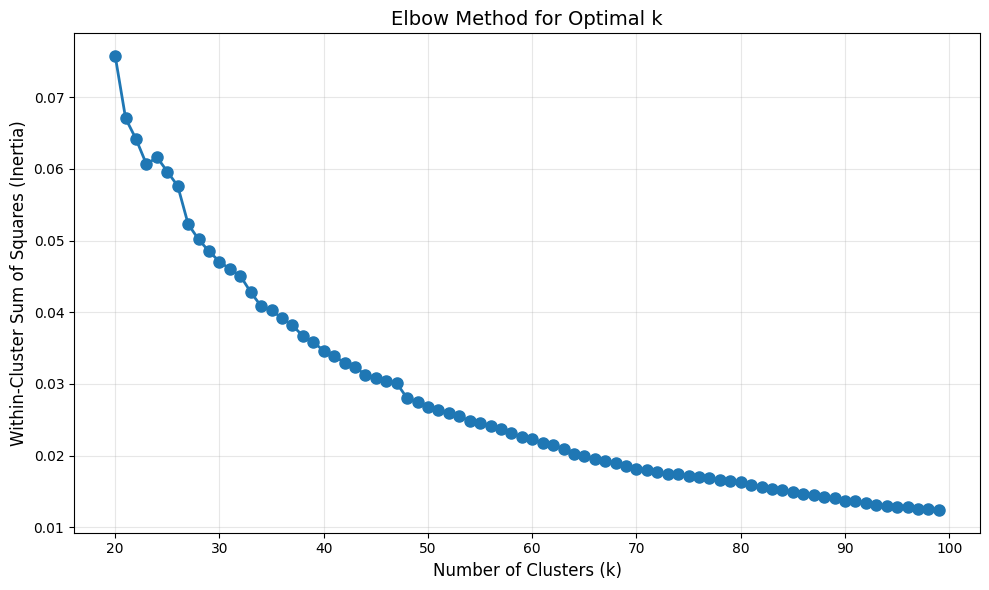

In [9]:
# Different k values
k_values = np.arange(20,100,1)

# ELBOW METHOD: Calculate inertia (within-cluster sum of squares) for each k
inertias = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(stations_coordinates[['latitude', 'longitude']])
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (Inertia)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\billy\AppData\Local\Temp\ipykernel_2792\3085029997.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_coordinates[f'cluster_{k}'] = clusters
C:\Users\billy\AppData\Local\Temp\ipykernel_2792\3085029997.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_coordinates[f'cluster_{k}'] = clusters
C:\Users\billy\AppData\Local\Temp\ipykernel_2792\3085029997.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

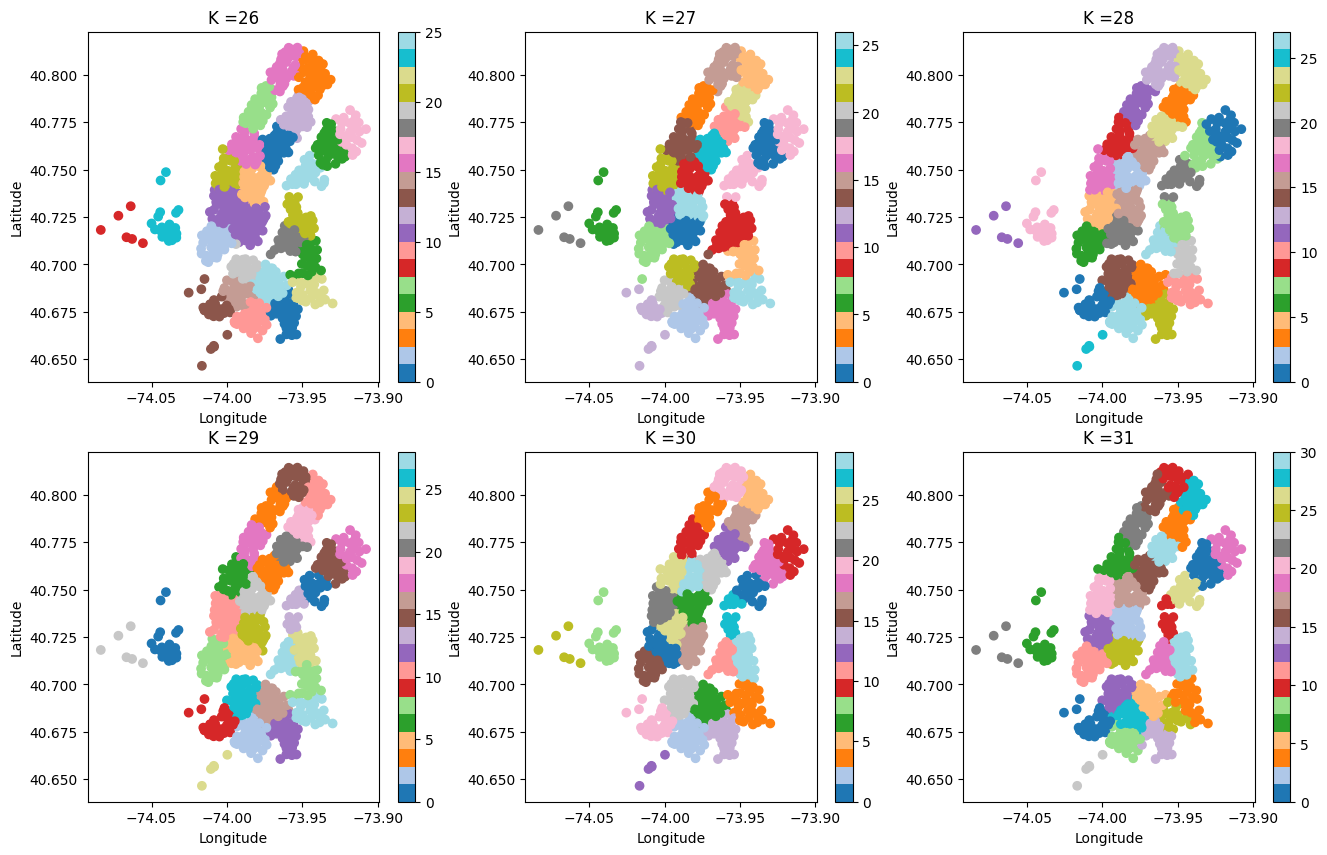

In [10]:
k_values = [26,27,28,29,30,31]

#Plot the clustering results for different k values for k-means clustering
fig,axes = plt.subplots(2,3,figsize=(16,10))
axes = axes.ravel()

for i,k in enumerate(k_values):
    #Fit k-means
    kmeans = KMeans(n_clusters=k,random_state=42,init='k-means++',n_init=10)
    clusters = kmeans.fit_predict(stations_coordinates[['latitude', 'longitude']])

    # Add cluster assignment as a new column for each k
    stations_coordinates[f'cluster_{k}'] = clusters

    scatter = axes[i].scatter(stations_coordinates['longitude'],stations_coordinates['latitude'],c=clusters,cmap='tab20')
    axes[i].set_title(f'K ={k}')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    plt.colorbar(scatter,ax=axes[i])

plt.show()

In [16]:
# Create a dictionary for fast lookup: station_id -> cluster_20
cluster_map = stations_coordinates.set_index('station_id')['cluster_27']

# Add new columns to dataframe with start and end stations' cluster index
data['start_cluster_27'] = data['start_station_id'].map(cluster_map)
data['end_cluster_27'] = data['end_station_id'].map(cluster_map).astype("Int32")

print(data[['start_cluster_27','end_cluster_27']])

          start_cluster_27  end_cluster_27
0                       14               8
1                       14              22
2                       14              22
3                       14              14
4                       14              14
...                    ...             ...
17480678                11              22
17480679                15              24
17480680                 7               7
17480681                15              24
17480682                11              26

[17480683 rows x 2 columns]


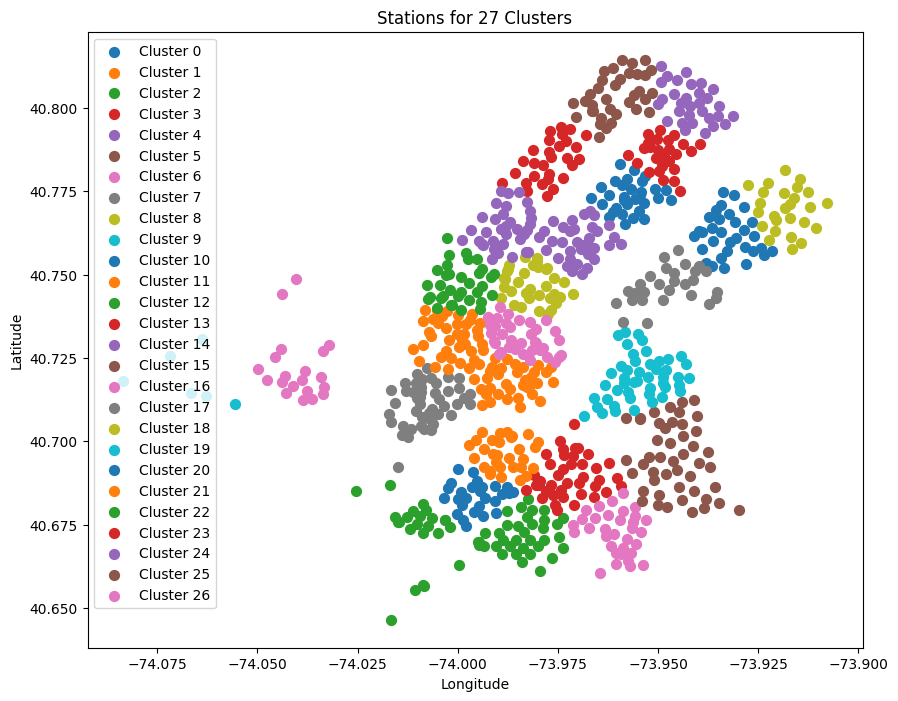

In [17]:
# Clusters to visualize
target_clusters = np.arange(0,27)

# Filter for target clusters
data_plot = stations_coordinates[stations_coordinates['cluster_27'].isin(target_clusters)]

# Plot the stations
plt.figure(figsize=(10, 8))
for cluster in target_clusters:
    cluster_data = data_plot[data_plot['cluster_27'] == cluster]
    plt.scatter(cluster_data['longitude'], cluster_data['latitude'], label=f'Cluster {cluster}', s=50)

plt.title('Stations for 27 Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

Use folium to visualise clustering of the dataset. This can help us choose the clusters we want to] make predictions for.

In [19]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Create a map centered on the data
map_center = [data_plot['latitude'].mean(), data_plot['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Generate a color for each cluster using a colormap
colormap = cm.get_cmap('tab20', len(target_clusters))
colors = [mcolors.to_hex(colormap(i)) for i in range(len(target_clusters))]

# Add markers for each cluster
for idx, cluster in enumerate(target_clusters):
    cluster_data = data_plot[data_plot['cluster_27'] == cluster]
    color = colors[idx]
    
    for _, row in cluster_data.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            color=color,
            radius=6,
            fill=True,
            fill_color=color,
            popup=f"Cluster: {cluster}"
        ).add_to(m)

m.save('clusters_map.html')

C:\Users\billy\AppData\Local\Temp\ipykernel_2792\1576599130.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab20', len(target_clusters))


Task 2: Choose cluster and perform pickups and dropoffs prediction for the next 24-hours

In [25]:
# Convert start_time and stop_time columns to datetime
data['start_time'] = pd.to_datetime(data['start_time'], format="%Y-%m-%d %H:%M:%S.%f")
data['stop_time'] = pd.to_datetime(data['stop_time'], format="%Y-%m-%d %H:%M:%S.%f")

data.head()


,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age,start_cluster_27,end_cluster_27
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26,14,8
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49,14,22
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62,14,22
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44,14,14
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26,14,14


Given a specific cluster, we filter the data by keeping only trips whose starting station belongs to the named cluster

In [53]:
target_clusters = [11]

data_filtered = data[data['start_cluster_27'].isin(target_clusters)].copy()

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1602323 entries, 4179 to 17480682
Data columns (total 15 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   start_station_id         1602323 non-null  float64       
 1   start_station_latitude   1602323 non-null  float64       
 2   start_station_longitude  1602323 non-null  float64       
 3   end_station_id           1602323 non-null  float64       
 4   end_station_latitude     1602323 non-null  float64       
 5   end_station_longitude    1602323 non-null  float64       
 6   bikeid                   1602323 non-null  int64         
 7   usertype                 1602323 non-null  int64         
 8   gender                   1602323 non-null  int64         
 9   start_time               1602323 non-null  datetime64[ns]
 10  stop_time                1602323 non-null  datetime64[ns]
 11  tripduration_min         1602323 non-null  float64       
 12  a

Pickups Prediction

In [54]:
# Create pickup hour and date columns
data_filtered['pickup_hour'] = data_filtered['start_time'].dt.hour
data_filtered['date'] = data_filtered['start_time'].dt.date

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1602323 entries, 4179 to 17480682
Data columns (total 17 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   start_station_id         1602323 non-null  float64       
 1   start_station_latitude   1602323 non-null  float64       
 2   start_station_longitude  1602323 non-null  float64       
 3   end_station_id           1602323 non-null  float64       
 4   end_station_latitude     1602323 non-null  float64       
 5   end_station_longitude    1602323 non-null  float64       
 6   bikeid                   1602323 non-null  int64         
 7   usertype                 1602323 non-null  int64         
 8   gender                   1602323 non-null  int64         
 9   start_time               1602323 non-null  datetime64[ns]
 10  stop_time                1602323 non-null  datetime64[ns]
 11  tripduration_min         1602323 non-null  float64       
 12  a

In [55]:
# Count pickups per hour, per day (for one cluster)
cluster_hourly = (
    data_filtered
    .groupby(['date', 'pickup_hour'])
    ['start_station_id']
    .size()
    .reset_index()
    .rename(columns={'start_station_id': 'pickups'})
)
cluster_hourly.head()

,date,pickup_hour,pickups
0,2018-01-01,0,11
1,2018-01-01,1,17
2,2018-01-01,2,8
3,2018-01-01,3,6
4,2018-01-01,4,3


In [56]:
cluster_hourly['datetime'] = pd.to_datetime(
    cluster_hourly['date'].astype(str) + ' ' +
    cluster_hourly['pickup_hour'].astype(str) + ':00:00'
)
cluster_hourly = cluster_hourly.sort_values('datetime')

In [154]:
# Ensure datetime index and hourly frequency
chd = (
    cluster_hourly
    .set_index('datetime')
    .sort_index()
    .asfreq('H')              # guarantees continuous hourly timeline
    .fillna({'pickups': 0})  # fill missing hours if any
)

# Make sure we only keep 2018 samples
chd_2018 = chd.loc['2018-01-01':'2018-12-31 23:00']

# Train: Jan–Oct 2018
train_data = chd.loc['2018-01-01':'2018-10-31 23:00', 'pickups']

# Test: Nov–Dec 2018
test_data  = chd.loc['2018-11-01 00:00':'2018-12-31 23:00', 'pickups']

C:\Users\billy\AppData\Local\Temp\ipykernel_2792\495717343.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .asfreq('H')              # guarantees continuous hourly timeline


C:\Users\billy\AppData\Local\Temp\ipykernel_2792\430030329.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=last_train_datetime + pd.Timedelta(hours=1), periods=24, freq='H')


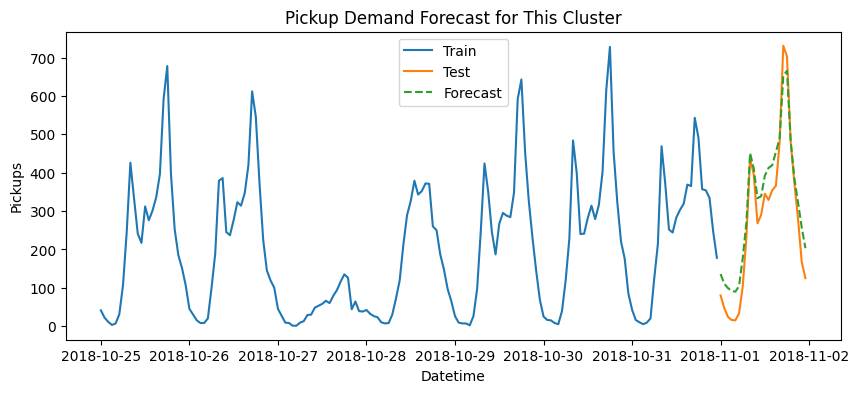

In [155]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit ARIMA model for this cluster
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted = model.fit(disp=False)

# Forecast next 24 hours
forecast = fitted.forecast(steps=24)

# Create forecast datetime index
last_train_datetime = train_data.index[-1]
forecast_index = pd.date_range(start=last_train_datetime + pd.Timedelta(hours=1), periods=24, freq='H')

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(train_data[-24*7:], label='Train')
plt.plot(test_data[:24], label='Test')
plt.plot(forecast_index, forecast, '--', label='Forecast')
plt.title('Pickup Demand Forecast for This Cluster')
plt.xlabel('Datetime')
plt.ylabel('Pickups')
plt.legend()
plt.show()

Mean Absolute Error for Pickups Prediction

In [179]:
y_true = chd_2018.loc['2018-11-01','pickups']
y_pred = forecast

mae = np.mean(np.abs(y_true - y_pred))
print("Mean Absolute Error is",mae)

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print("RMSE is",rmse)

Mean Absolute Error is 54.41254897787082
RMSE is 60.666426409850274


Dropoffs Prediction

In [60]:
data_filtered_dropoffs = data[data['end_cluster_27'].isin(target_clusters)].copy()

data_filtered_dropoffs['dropoff_hour'] = data_filtered['stop_time'].dt.hour.astype("Int32")
data_filtered_dropoffs['date'] = data_filtered['stop_time'].dt.date

data_filtered_dropoffs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1631383 entries, 10 to 17480673
Data columns (total 17 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   start_station_id         1631383 non-null  float64       
 1   start_station_latitude   1631383 non-null  float64       
 2   start_station_longitude  1631383 non-null  float64       
 3   end_station_id           1631383 non-null  float64       
 4   end_station_latitude     1631383 non-null  float64       
 5   end_station_longitude    1631383 non-null  float64       
 6   bikeid                   1631383 non-null  int64         
 7   usertype                 1631383 non-null  int64         
 8   gender                   1631383 non-null  int64         
 9   start_time               1631383 non-null  datetime64[ns]
 10  stop_time                1631383 non-null  datetime64[ns]
 11  tripduration_min         1631383 non-null  float64       
 12  age

In [61]:
# Count dropoffs per hour, per day (for this cluster)
cluster_hourly_drops = (
    data_filtered_dropoffs
    .groupby(['date', 'dropoff_hour'])
    ['end_station_id']
    .size()
    .reset_index()
    .rename(columns={'end_station_id': 'dropoffs'})
)


In [62]:
cluster_hourly_drops['datetime'] = pd.to_datetime(
    cluster_hourly_drops['date'].astype(str) + ' ' +
    cluster_hourly_drops['dropoff_hour'].astype(str) + ':00:00'
)
cluster_hourly_drops = cluster_hourly_drops.sort_values('datetime')
cluster_hourly_drops.head()

,date,dropoff_hour,dropoffs,datetime
0,2018-01-01,0,2,2018-01-01 00:00:00
1,2018-01-01,1,3,2018-01-01 01:00:00
2,2018-01-01,2,2,2018-01-01 02:00:00
3,2018-01-01,4,1,2018-01-01 04:00:00
4,2018-01-01,6,1,2018-01-01 06:00:00


In [63]:
# Ensure datetime index and hourly frequency
chd_drop = (
    cluster_hourly_drops
    .set_index('datetime')
    .sort_index()
    .asfreq('H')              # guarantees continuous hourly timeline
    .fillna({'dropoffs': 0})  # fill missing hours if any
)

# Keep only 2018 samples
chd_2018_drop = chd_drop.loc['2018-01-01':'2018-12-31 23:00']

# Train: Jan–Oct 2018
train_data_drop = chd_2018_drop.loc['2018-01-01':'2018-10-31 23:00', 'dropoffs']
print(train_data_drop)

# Test: Nov–Dec 2018
test_data_drop  = chd_2018_drop.loc['2018-11-01 00:00':'2018-12-31 23:00', 'dropoffs']


datetime
2018-01-01 00:00:00     2.0
2018-01-01 01:00:00     3.0
2018-01-01 02:00:00     2.0
2018-01-01 03:00:00     0.0
2018-01-01 04:00:00     1.0
                       ... 
2018-10-31 19:00:00    92.0
2018-10-31 20:00:00    94.0
2018-10-31 21:00:00    65.0
2018-10-31 22:00:00    58.0
2018-10-31 23:00:00    28.0
Freq: h, Name: dropoffs, Length: 7296, dtype: float64


C:\Users\billy\AppData\Local\Temp\ipykernel_2792\490359717.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .asfreq('H')              # guarantees continuous hourly timeline


C:\Users\billy\AppData\Local\Temp\ipykernel_2792\1894603461.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_drop_index = pd.date_range(start=train_data_drop.index[-1] + pd.Timedelta(hours=1),periods=24, freq='H')


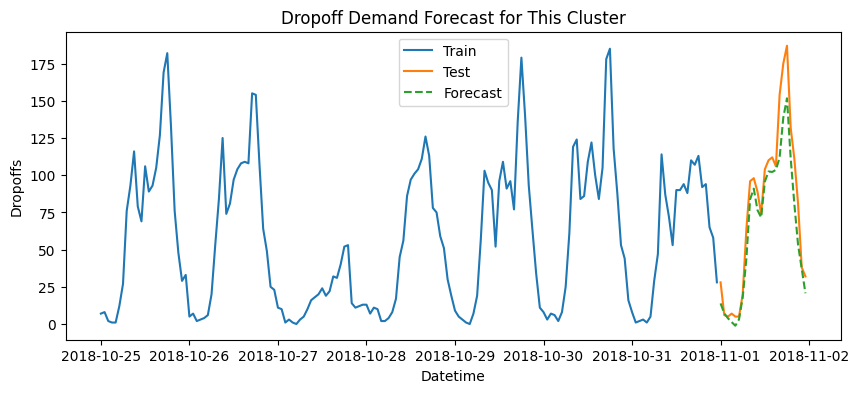

In [64]:
# Fit ARIMA model for this cluster
model = SARIMAX(train_data_drop, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted = model.fit(disp=False)

# Forecast next 24 hours
forecast_drop = fitted.forecast(steps=24)

# Create forecast datetime index
last_train_datetime = train_data_drop.index[-1]
forecast_drop_index = pd.date_range(start=train_data_drop.index[-1] + pd.Timedelta(hours=1),periods=24, freq='H')

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(train_data_drop[-24*7:], label='Train')
plt.plot(test_data_drop[:24], label='Test')
plt.plot(forecast_drop_index, forecast_drop, '--', label='Forecast')
plt.title('Dropoff Demand Forecast for This Cluster')
plt.xlabel('Datetime')
plt.ylabel('Dropoffs')
plt.legend()
plt.show()

In [182]:
y_true = chd_2018_drop.loc['2018-11-01','dropoffs']
y_pred = forecast

mae = np.mean(np.abs(y_true - y_pred))
print("Mean Absolute Error is",mae)

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print("RMSE is",rmse)

Mean Absolute Error is 246.20132066744245
RMSE is 271.5615125449249


TASK 3

This implementation is more interactive. We let the user pick the date they want to predict the number of bikes that need to be repositioned. Then, we dynamically select train and test dataset and use timeseries to find the hourly net flow of the cluster.

In [99]:
hourly_2018_pickups = chd_2018.loc['2018-01-01':'2018-12-31 23:00','pickups']
hourly_2018_dropoffs = chd_2018_drop.loc['2018-01-01':'2018-12-31 23:00','dropoffs']
hourly_2018_pickups_dropoffs = pd.concat([hourly_2018_pickups,hourly_2018_dropoffs], axis=1)
hourly_2018_pickups_dropoffs.head()

,pickups,dropoffs
datetime,,
2018-01-01 00:00:00,11.0,2.0
2018-01-01 01:00:00,17.0,3.0
2018-01-01 02:00:00,8.0,2.0
2018-01-01 03:00:00,6.0,0.0
2018-01-01 04:00:00,3.0,1.0


In [139]:
# Prompt the user to input the date
date_input = input("Enter the date for which you want to predict reposition needs (YYYY-MM-DD): ")

# Parse the input as a datetime
import datetime
try:
    target_date = datetime.datetime.strptime(date_input, "%Y-%m-%d").date()
    print(f"Processing reposition needs for: {target_date}")
except ValueError:
    print("Invalid date format. Please enter the date in YYYY-MM-DD format.")

Processing reposition needs for: 2018-11-01


In [140]:
# Train data: Strictly before the given date
# Test data: Includes all dates from the input date and after
train_net_pick = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index < date_input,'pickups']
test_net_pick = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index >= date_input,'pickups']

train_net_drop = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index < date_input,'dropoffs']
test_net_drop = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index >= date_input,'dropoffs']


# Fit ARIMA model for this cluster
model1 = SARIMAX(train_net_pick, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted1 = model1.fit(disp=False)

model2 = SARIMAX(train_net_drop, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted2 = model2.fit(disp=False)

# Forecast next 24 hours pickups and dropoffs
fc_pickups = fitted1.forecast(steps=24)
fc_dropoffs = fitted2.forecast(steps=24)


In [141]:
picks_forecast_df = pd.DataFrame(fc_pickups)
picks_forecast_df.columns = ['pickups']
picks_forecast_df.index.name = 'datetime'
#picks_forecast_df.info()

drops_forecast_df = pd.DataFrame(fc_dropoffs)
drops_forecast_df.columns = ['dropoffs']
drops_forecast_df.index.name = 'datetime'
#drops_forecast_df.info()

# Combine forecasts into one DataFrame
forecast_next_day = pd.concat([picks_forecast_df, drops_forecast_df], axis=1)
forecast_next_day

,pickups,dropoffs
datetime,,
2018-11-01 00:00:00,135.743173,13.848158
2018-11-01 01:00:00,110.557129,7.155058
2018-11-01 02:00:00,99.141595,3.862839
2018-11-01 03:00:00,91.725657,1.284308
2018-11-01 04:00:00,89.686584,-1.141042
2018-11-01 05:00:00,104.195809,3.144081
2018-11-01 06:00:00,176.898727,17.917023
2018-11-01 07:00:00,270.202270,44.136223
2018-11-01 08:00:00,451.353368,83.782895


In [142]:
# Calculate net flow: pickups = departures
net_flow = forecast_next_day['pickups'] - forecast_next_day['dropoffs']
forecast_next_day['net'] = net_flow
forecast_next_day



,pickups,dropoffs,net
datetime,,,
2018-11-01 00:00:00,135.743173,13.848158,121.895014
2018-11-01 01:00:00,110.557129,7.155058,103.402071
2018-11-01 02:00:00,99.141595,3.862839,95.278756
2018-11-01 03:00:00,91.725657,1.284308,90.441349
2018-11-01 04:00:00,89.686584,-1.141042,90.827626
2018-11-01 05:00:00,104.195809,3.144081,101.051728
2018-11-01 06:00:00,176.898727,17.917023,158.981704
2018-11-01 07:00:00,270.202270,44.136223,226.066047
2018-11-01 08:00:00,451.353368,83.782895,367.570473


In [143]:
mask = forecast_next_day.index.date == target_date
day_netflow = forecast_next_day.loc[mask, 'net'].max()

# Required bikes at start of day
required_bikes = math.ceil(max(0, day_netflow))
print(f"Number of bikes to reposition on {target_date} is: {required_bikes}")

Number of bikes to reposition on 2018-11-01 is: 515
